In [2]:
import os
import json

from argparse import Namespace 
import matplotlib.pyplot as plt 
import numpy as np
import torch


from bigram_estimator import getWordDict, getNgramDict, pLM
from generate_watermark import load_model, generate
from likelihood_ratio_test import L_Gw

/Users/wayne/miniconda3/envs/lm-watermarking1/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
args = Namespace()

arg_dict = {
    'run_gradio': False, 
    'demo_public': False,
    'model_name_or_path': 'facebook/opt-350m', 
    # 'model_name_or_path': 'facebook/opt-1.3b', 
    # 'model_name_or_path': 'facebook/opt-2.7b', 
    # 'model_name_or_path': 'facebook/opt-6.7b',
    # 'model_name_or_path': 'facebook/opt-13b',
    # 'load_fp16' : True,
    'load_fp16' : False,
    'prompt_max_length': None, 
    'max_new_tokens': 200, 
    'generation_seed': 123, 
    'use_sampling': True, 
    'n_beams': 1, 
    'sampling_temp': 0.7, 
    
    # 'use_gpu': True, 
    'use_gpu': False, 
    'seeding_scheme': 'simple_1', 
    'gamma': 0.25, 
    'delta': 2.0, 
    'normalizers': '', 
    'ignore_repeated_bigrams': False, 
    'detection_z_threshold': 4.0, 
    'select_green_tokens': True,
    'skip_model_load': False,
    'seed_separately': True,
}

args.__dict__.update(arg_dict)

args.is_seq2seq_model = any([(model_type in args.model_name_or_path) for model_type in ["t5","T0"]])
args.is_decoder_only_model = any([(model_type in args.model_name_or_path) for model_type in ["gpt","opt","bloom"]])


In [3]:
model, tokenizer, device = load_model(args)

In [4]:
times = 1 #1000
tokd_input, watermark_processor, output, corpus_without_watermark, corpus_with_watermark, _ = generate("",
                                                                    args,
                                                                    model=model,
                                                                    device=device,
                                                                    tokenizer=tokenizer,
                                                                    times=times)

Generating with Namespace(run_gradio=False, demo_public=False, model_name_or_path='facebook/opt-350m', load_fp16=False, prompt_max_length=None, max_new_tokens=200, generation_seed=123, use_sampling=True, n_beams=1, sampling_temp=0.7, use_gpu=False, seeding_scheme='simple_1', gamma=0.25, delta=2.0, normalizers='', ignore_repeated_bigrams=False, detection_z_threshold=4.0, select_green_tokens=True, skip_model_load=False, seed_separately=True, is_seq2seq_model=False, is_decoder_only_model=True)


To load whole corpora. Only use when analysing over larger corpora

## Computing $\sup_{\theta \in \Theta} L(\theta)$

In [3]:
# Helper functions

def getGreenlist(w, tokenizer=None, watermark_processor=None):
    greenlist_w, redlist_w = watermark_processor._get_greenlist_ids(torch.tensor(tokenizer.encode(w)), get_redlist=True)
    greenlist_w = tokenizer.convert_ids_to_tokens(greenlist_w)
    redlist_w = tokenizer.convert_ids_to_tokens(redlist_w)
    return greenlist_w, redlist_w

def getTokenizedCorpus(corpus, tokenizer=None):
    # Returns tokenized corpus, subword by subword, as well as the encoded corpus
    words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(corpus)
    tokenized_corpus = list(zip(*words_with_offsets))[0]
    corpus_t = tokenizer.encode(corpus, add_special_tokens=False)
    return tokenized_corpus, corpus_t


In [ ]:
# def L_Gw(delta, w, corpus, watermark_processor, tokenizer, model):
#     expdelta = torch.exp(delta)
#     greenlist_w, redlist_w = getGreenlist(w, watermark_processor)

#     words_with_offsets = tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(corpus)
#     tokenized_corpus = list(zip(*words_with_offsets))[0]
    
#     corpus_t = tokenizer.encode(corpus, add_special_tokens=False)

#     with torch.inference_mode():
#         output = model(torch.tensor([corpus_t]))
#     soft_logits = torch.softmax(output.logits[0], dim=1)

#     green = torch.zeros(output.logits.size(1))
#     red = torch.zeros(output.logits.size(1))

#     for wdash in greenlist_w:
#         green += pLM(wdash, tokenizer, soft_logits)

#     for wdash in redlist_w:
#         red += pLM(wdash, tokenizer, soft_logits)

#     deltas = torch.zeros(output.logits.size(1))
#     for i in range(output.logits.size(1)):
#         if tokenized_corpus[i] in greenlist_w:
#             deltas[i] = deltas[i] + delta
    
#     Lvector = torch.log(pLM(tokenized_corpus, tokenizer, soft_logits)) + deltas - torch.log(expdelta * green + red)

#     L_final = torch.sum(Lvector)
#     return L_final

In [3]:
def L_Gw2(delta, w, corpus, watermark_processor, tokenizer, model):
    L_tot = 0
    expdelta = torch.exp(delta)
    greenlist_w, redlist_w = getGreenlist(w, watermark_processor)
    for sentence in corpus[0].split("  "): # We can actually just feed bigram to bigram here?
        tokenized_corpus, corpus_t = getTokenizedCorpus(sentence, tokenizer=tokenizer)

        with torch.inference_mode():
            output = model(torch.tensor([corpus_t]))
        soft_logits = torch.softmax(output.logits[0], dim=1)

        indices = [i for i, x in enumerate(tokenized_corpus) if x == w]
        # indices = [i + 1 for i in indices] ## DO WE NEED THIS INDEX SHIFT OR NOT?
        soft_logits_filtered = soft_logits[indices,:]
        green = torch.zeros(len(indices))
        red = torch.zeros(len(indices))
        for wdash in greenlist_w:
            green += pLM(wdash, tokenizer, soft_logits_filtered)
        for wdash in redlist_w:
            red += pLM(wdash, tokenizer, soft_logits_filtered)
        deltas = torch.zeros(len(indices))
        for i in range(len(indices)):
            if tokenized_corpus[indices[i]] in greenlist_w:
                deltas[i] = deltas[i] + delta
        Lvector = deltas - torch.log(expdelta * green + red)

        Lol = torch.sum(Lvector)
        L_tot += Lol
    return L_tot, Lvector

In [15]:
delta_init = torch.tensor(0.1)
delta_init.requires_grad = True
loss = torch.tensor(1.)
loss.requires_grad = True
tol = 1e-9
deltaarr = torch.linspace(0, 1, 50)
delta = torch.tensor(.2)
w = 'Ġbrown'
sentence = "The quick brown fox jumps over the lazy brown dog"#

## Gradient Descent

In [31]:
optimizer = torch.optim.SGD([delta_init], lr=0.01)

epochs = 10
# look at the gradient of delta too!

def L_Gw_delta(delta):
  return L_Gw2(delta, w, sentence, watermark_processor, tokenizer, model)

for _ in range(epochs):
  # print(f"Loss = {loss.item()}")
  optimizer.zero_grad()
  loss = -L_Gw_delta(delta_init)
  loss.backward()
  optimizer.step()
  print(f"Loss = {loss.item()}, delta_grad = {optimizer.param_groups[0]['params'][0].grad}, delta = {delta_init.item()}")


print(f'found optimal value of delta={delta_init.item()}, with LGWDelta(delta)={L_Gw_delta(delta_init).item()}')


Loss = -0.038755159825086594, delta_grad = 0.2006731480360031, delta = -0.18030165135860443
Loss = -0.039157480001449585, delta_grad = 0.20031802356243134, delta = -0.18230482935905457
Loss = -0.03955836594104767, delta_grad = 0.19996406137943268, delta = -0.18430447578430176
Loss = -0.039957884699106216, delta_grad = 0.19961127638816833, delta = -0.186300590634346
Loss = -0.04035603255033493, delta_grad = 0.1992596536874771, delta = -0.1882931888103485
Loss = -0.04075268656015396, delta_grad = 0.19890917837619781, delta = -0.19028228521347046
Loss = -0.041148025542497635, delta_grad = 0.19855988025665283, delta = -0.19226787984371185
Loss = -0.0415419302880764, delta_grad = 0.19821174442768097, delta = -0.19425000250339508
Loss = -0.041934460401535034, delta_grad = 0.19786469638347626, delta = -0.19622865319252014
Loss = -0.042325615882873535, delta_grad = 0.19751881062984467, delta = -0.19820384681224823
found optimal value of delta=-0.19820384681224823, with LGWDelta(delta)=0.042715

In [29]:
optimizer.param_groups[0]['params'][0].grad

tensor(0.2437)

In [12]:
# deltaarr = torch.linspace(0, 1, 50)
# delta = torch.tensor(.2)
# w = 'Ġbrown'
# sentence = "The quick brown fox jumps over the lazy brown dog"#
g_quick = getGreenlist('Ġquick', watermark_processor)
g_fox = getGreenlist('Ġfox', watermark_processor)
g_over = getGreenlist('Ġover', watermark_processor)
g_the = getGreenlist('Ġthe', watermark_processor)



Lol = L_Gw2(delta, w, sentence, watermark_processor, tokenizer, model)
# print(Lol)
# print(Lvector)
print(f"brown is in G_quick = {'Ġbrown' in g_quick}")
print(f"jumps is in G_fox = {'Ġjumps' in g_fox}")
print(f"the is in G_over = {'Ġthe' in g_over}")
print(f"lazy is in G_the = {'Ġlazy' in g_the}")




green + red = tensor([1.0000, 1.0000])
tensor([0., 0.])
brown is in G_quick = False
jumps is in G_fox = False
the is in G_over = False
lazy is in G_the = False


In [4]:
deltaarr = torch.linspace(0, 1, 10)
w = 'Ġbrown'
sentence = "The quick brown fox jumps over the lazy brown dog"#


Larr = torch.zeros(deltaarr.size(0))
for i in range(deltaarr.size(0)):
    Larr[i] = L_Gw2(deltaarr[i], w, sentence, watermark_processor, tokenizer, model)
plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'brown\')")
plt.show()

NameError: name 'watermark_processor' is not defined

In [75]:

# print(deltaarr.size(0))
# w = 'Ġup'
sentence = "The quick brown fox jumps over the lazy dog"
sentences = corpus_without_watermark[0].split("   ")

Larr = torch.zeros(deltaarr.size(0))
for j in range(len(sentences)):
    for i in range(deltaarr.size(0)):
        Larr[i] = L_Gw(deltaarr[i], w, sentences[j], watermark_processor, tokenizer, model)
Larr

tensor([ 5.1911e-04, -2.7738e-02, -5.7575e-02, -8.9007e-02, -1.2205e-01,
        -1.5671e-01, -1.9300e-01, -2.3095e-01, -2.7055e-01, -3.1183e-01,
        -3.5480e-01, -3.9946e-01, -4.4584e-01, -4.9394e-01, -5.4377e-01,
        -5.9535e-01, -6.4869e-01, -7.0380e-01, -7.6070e-01, -8.1938e-01,
        -8.7987e-01, -9.4217e-01, -1.0063e+00, -1.0723e+00, -1.1401e+00,
        -1.2097e+00, -1.2813e+00, -1.3547e+00, -1.4299e+00, -1.5071e+00,
        -1.5862e+00, -1.6671e+00, -1.7500e+00, -1.8349e+00, -1.9216e+00,
        -2.0103e+00, -2.1009e+00, -2.1935e+00, -2.2880e+00, -2.3845e+00,
        -2.4830e+00, -2.5834e+00, -2.6858e+00, -2.7902e+00, -2.8966e+00,
        -3.0050e+00, -3.1154e+00, -3.2278e+00, -3.3422e+00, -3.4586e+00])

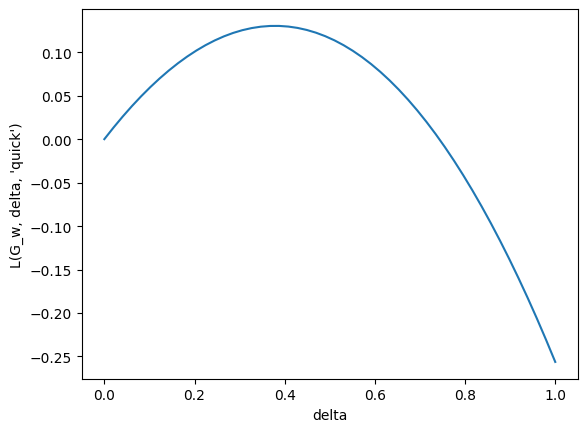

In [86]:
plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'quick\')")
plt.show()

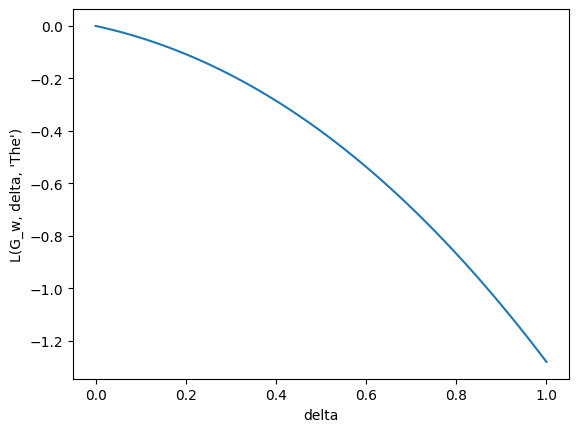

In [89]:
deltaarr = torch.linspace(0, 1, 50)
w = 'The'
sentence = "The quick brown fox jumps over the lazy dog"#


Larr = torch.zeros(deltaarr.size(0))
for i in range(deltaarr.size(0)):
    Larr[i] = L_Gw(deltaarr[i], w, sentence, watermark_processor, tokenizer, model)

plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'The\')")
plt.show()

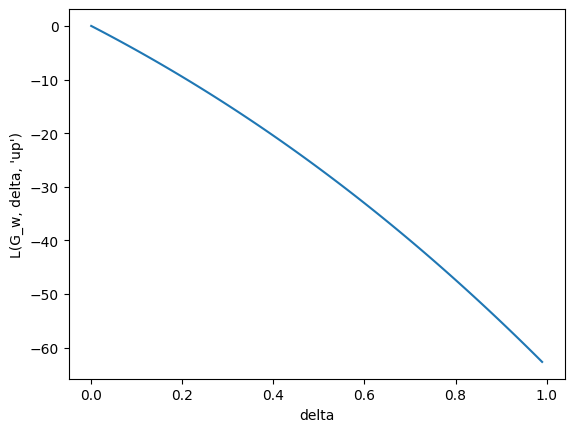

In [63]:
plt.plot(deltaarr, Larr)
plt.xlabel("delta")
plt.ylabel("L(G_w, delta, \'up\')")
plt.show()

## Sanity check
- Check greenlist, check predicted delta
- Try to "recover" delta given wmarked text. Dump wmarked text back into optimiser and see what delta comes out.
- If we see sth is in the greenlist then the gradient should be "steeper"

In [70]:
args_test = Namespace()

arg_dict_test = {
    'run_gradio': False, 
    'demo_public': False,
    'model_name_or_path': 'facebook/opt-350m', 
    # 'model_name_or_path': 'facebook/opt-1.3b', 
    # 'model_name_or_path': 'facebook/opt-2.7b', 
    # 'model_name_or_path': 'facebook/opt-6.7b',
    # 'model_name_or_path': 'facebook/opt-13b',
    # 'load_fp16' : True,
    'load_fp16' : False,
    'prompt_max_length': None, 
    'max_new_tokens': 200, 
    'generation_seed': 456, 
    'use_sampling': True, 
    'n_beams': 1, 
    'sampling_temp': 1, # 0.7, # we want to sample exactly from the wm-ed distribution
    
    # 'use_gpu': True, 
    'use_gpu': False, 
    'seeding_scheme': 'simple_1', 
    'gamma': 0.25, 
    'delta': 1.5, 
    'normalizers': '', 
    'ignore_repeated_bigrams': False, 
    'detection_z_threshold': 4.0, 
    'select_green_tokens': True,
    'skip_model_load': False,
    'seed_separately': True,
}

args_test.__dict__.update(arg_dict_test)

args_test.is_seq2seq_model = any([(model_type in args_test.model_name_or_path) for model_type in ["t5","T0"]])
args_test.is_decoder_only_model = any([(model_type in args_test.model_name_or_path) for model_type in ["gpt","opt","bloom"]])


model_2, tokenizer_2, device_2 = load_model(args_test)

times = 2 #1000
tokd_input_2, watermark_processor_2, output_2, corpus_without_watermark_2, corpus_with_watermark_2, _ = generate("",
                                                                    args_test,
                                                                    model=model_2,
                                                                    device=device_2,
                                                                    tokenizer=tokenizer_2,
                                                                    times=times)

Generating with Namespace(run_gradio=False, demo_public=False, model_name_or_path='facebook/opt-350m', load_fp16=False, prompt_max_length=None, max_new_tokens=200, generation_seed=456, use_sampling=True, n_beams=1, sampling_temp=1, use_gpu=False, seeding_scheme='simple_1', gamma=0.25, delta=1.5, normalizers='', ignore_repeated_bigrams=False, detection_z_threshold=4.0, select_green_tokens=True, skip_model_load=False, seed_separately=True, is_seq2seq_model=False, is_decoder_only_model=True)


In [65]:
from nltk.util import ngrams


def L_Gw_sanity(delta, w, corpus, watermark_processor, tokenizer, model):
    L_tot = 0
    expdelta = torch.exp(delta)
    greenlist_w, redlist_w = getGreenlist(w, tokenizer, watermark_processor)
    tokenized_corpus, corpus_t = getTokenizedCorpus(corpus, tokenizer=tokenizer)
    with torch.inference_mode():
        output = model(torch.tensor([corpus_t]))
    soft_logits = torch.softmax(output.logits[0], dim=1)
    bigram_list = list(ngrams(tokenized_corpus, 2))
    bigram_vector = torch.zeros(len(bigram_list))
    for j in range(len(bigram_list)):
        bigram = bigram_list[j]
        # print(bigram) 
        # indices = [i for i, x in enumerate(bigram) if x == w]
        indices = [0] if bigram[0] == w else []
        # indices = [i + 1 for i in indices] ## DO WE NEED THIS INDEX SHIFT OR NOT?
        soft_logits_filtered = soft_logits[indices,:]
        green = torch.zeros(len(indices))
        red = torch.zeros(len(indices))
        for wdash in greenlist_w:
            green += pLM(wdash, tokenizer, soft_logits_filtered)
        for wdash in redlist_w:
            red += pLM(wdash, tokenizer, soft_logits_filtered)
        deltas = torch.zeros(len(indices))
        for i in range(len(indices)):
            if tokenized_corpus[indices[i]] in greenlist_w:
                deltas[i] = deltas[i] + delta
        Lvector = deltas - torch.log(expdelta * green + red)

        Lol = torch.sum(Lvector)
        
        #L_tot += Lol
        bigram_vector[j] = Lol
    L_tot = torch.sum(bigram_vector)
    return L_tot, bigram_vector, bigram_list

In [66]:
delta_2 = torch.tensor(0.5)
w = 'Ġand'
L_total, bigram_vector, bigram_list = L_Gw_sanity(delta_2, w, corpus_with_watermark_2, watermark_processor_2, tokenizer_2, model_2)

In [67]:
bigram_vector

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.1586,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

In [68]:
ind = torch.argwhere(bigram_vector != 0)[:,0]
ind

tensor([ 46, 174, 198, 254, 259, 275, 311, 331, 339, 343, 357])

In [69]:
[bigram_list[i] for i in ind]

[('Ġand', 'Ġthat'),
 ('Ġand', 'Ġget'),
 ('Ġand', 'Ġsee'),
 ('Ġand', 'Ġhis'),
 ('Ġand', 'ĠDonnie'),
 ('Ġand', 'Ġwatches'),
 ('Ġand', 'ĠSusan'),
 ('Ġand', 'Ġthey'),
 ('Ġand', 'ĠWahlberg'),
 ('Ġand', 'Ġthey'),
 ('Ġand', 'ĠWahlberg')]

In [64]:
delta_2 = torch.tensor(0.5)
delta_init = torch.tensor(0.1)
delta_init.requires_grad = True
loss = torch.tensor(1.)
loss.requires_grad = True
tol = 1e-9
deltaarr = torch.linspace(0, 1, 50)
delta = torch.tensor(.2)

w = 'Ġthe'
optimizer = torch.optim.SGD([delta_init], lr=0.01) # use normal gd

epochs = 10
# look at the gradient of delta too!

def L_Gw_delta(delta):
  return L_Gw2(delta, w, corpus_with_watermark_2, watermark_processor_2, tokenizer_2, model_2)

for _ in range(epochs):
  optimizer.zero_grad()
  loss = -L_Gw_delta(delta_init)
  loss.backward()
  optimizer.step()
  print(f"Loss = {loss.item()}, delta_grad = {optimizer.param_groups[0]['params'][0].grad}, delta = {delta_init.item()}")


print(f'found optimal value of delta={delta_init.item()}, with LGWDelta(delta)={L_Gw_delta(delta_init).item()}')


Loss = 0.358028769493103, delta_grad = 3.6753299236297607, delta = 0.0632467046380043
Loss = 0.2242278754711151, delta_grad = 3.605769634246826, delta = 0.02718900889158249
Loss = 0.09543599933385849, delta_grad = 3.5379409790039062, delta = -0.008190400898456573
Loss = -0.028563037514686584, delta_grad = 3.4718120098114014, delta = -0.04290851950645447
Loss = -0.14797742664813995, delta_grad = 3.4073495864868164, delta = -0.07698201388120651
Loss = -0.2630062401294708, delta_grad = 3.344520330429077, delta = -0.11042721569538116
Loss = -0.37383919954299927, delta_grad = 3.283287286758423, delta = -0.14326009154319763
Loss = -0.48065802454948425, delta_grad = 3.223616361618042, delta = -0.17549625039100647
Loss = -0.5836367011070251, delta_grad = 3.1654696464538574, delta = -0.20715095102787018
Loss = -0.6829408407211304, delta_grad = 3.108811140060425, delta = -0.23823906481266022
found optimal value of delta=-0.23823906481266022, with LGWDelta(delta)=0.7787284255027771
